In [1]:
from CNNBiLSTM_LoadData import load_data
from tensorflow.keras.utils import to_categorical
import numpy as np

data_batches = load_data('VideoFrameAudio-Simple-40',process_audio = False)

for item in data_batches:
    normalized_images = [image_data / 255.0 for image_data in item['images']]
    item['images'] = np.array(normalized_images)

from tensorflow.keras.utils import to_categorical
image_data = [item['images'] for item in data_batches]
image_data = np.array(image_data)


categories = [item['category'] for item in data_batches]
categories = np.array(categories)
num_classes = len(np.unique(categories))
labels = to_categorical(categories, num_classes)

2024-01-05 18:01:26.142013: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-05 18:01:26.214922: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-05 18:01:27.192565: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


categories ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad']
start process Anger all imagefiles 2667 all audiofiles 2667
start process Disgust all imagefiles 2793 all audiofiles 2793
start process Fear all imagefiles 2369 all audiofiles 2369
start process Happy all imagefiles 2231 all audiofiles 2231
start process Neutral all imagefiles 2124 all audiofiles 2124
start process Sad all imagefiles 2511 all audiofiles 2511
process all files


In [2]:
# 调整形状，适应新网络
print(image_data.shape)
print(labels.shape)
X = image_data.reshape(-1, 50,50,3)
y = np.repeat(labels, repeats=10, axis=0)
print(X.shape)
print(y.shape)

(1467, 10, 50, 50, 3)
(1467, 6)
(14670, 50, 50, 3)
(14670, 6)


In [3]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, MaxPooling2D, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from keras.optimizers import Adam

# 加载前面训练好的模型
pretrained_resnet18_model = tf.keras.models.load_model("Weights/ResNet18_RAVDESS.h5")
# 去掉最后一层全连接层
new_resnet18 = Model(inputs=pretrained_resnet18_model.input, 
                                   outputs=pretrained_resnet18_model.layers[-2].output)
# 将特征提取器的所有层设置为不可训练的
for layer in new_resnet18.layers:
    layer.trainable = False
    
outputs = Dense(6, activation='softmax')(new_resnet18.output)

model = Model(inputs= new_resnet18.input, outputs=outputs)
model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


2024-01-05 18:01:41.034001: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 895 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:18:00.0, compute capability: 8.9


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 50, 50, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 25, 25, 64)           9408      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 25, 25, 64)           256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 25, 25, 64)           0         ['batch_normalization[0]

In [4]:
# 配置模型检查点
from keras.callbacks import ModelCheckpoint
from sklearn.utils import shuffle
checkpoint = ModelCheckpoint(
    'temp/CNNBiLSTM_image_resnet182d_{epoch:02d}.h5',  # 文件路径，其中{epoch:02d}是格式化字符串，用于在文件名中包含epoch编号
    monitor='val_accuracy',            # 可以是'val_loss', 'val_accuracy', 'loss', 'accuracy'等
    verbose=1,                        # 日志显示模式，0或1
    save_best_only=False,             # 如果设置为True，则只保存在验证集上性能最好的模型
    save_weights_only=False,          # 如果设置为True，则只保存模型的权重，如果为False，则保存整个模型
    mode='auto',                      # 可以是'auto', 'min', 'max'，决定了监控指标是应该最大化还是最小化
    save_freq='epoch'                 # 检查点之间的间隔（每个epoch）
)
X_shuffle, y_shuffle = shuffle(X, y, random_state=42) # random_state 参数确保了结果可以复现
history = model.fit(
    X_shuffle, y_shuffle, 
    epochs=50, 
    batch_size=100, 
    # validation_data=(x_val, y_val),
    validation_split=0.3,
    callbacks=[checkpoint],
    verbose=1,
    workers=128,
    shuffle=True
)

Epoch 1/50


2024-01-05 18:01:49.619768: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2024-01-05 18:01:49.836879: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-01-05 18:01:50.091280: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x8bf5e60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-05 18:01:50.091308: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2024-01-05 18:01:50.098453: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-01-05 18:01:50.264826: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the proces

103/103 [==============================] - ETA: 0s - loss: 2.3630 - accuracy: 0.1166
Epoch 1: saving model to temp/CNNBiLSTM_image_resnet182d_01.h5


/root/miniconda3/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


103/103 [==============================] - 5s 25ms/step - loss: 2.3630 - accuracy: 0.1166 - val_loss: 2.2455 - val_accuracy: 0.1218
Epoch 2/50
102/103 [============================>.] - ETA: 0s - loss: 2.1518 - accuracy: 0.1148
Epoch 2: saving model to temp/CNNBiLSTM_image_resnet182d_02.h5
103/103 [==============================] - 2s 15ms/step - loss: 2.1519 - accuracy: 0.1145 - val_loss: 2.0644 - val_accuracy: 0.1254
Epoch 3/50
 98/103 [===========================>..] - ETA: 0s - loss: 1.9887 - accuracy: 0.1264
Epoch 3: saving model to temp/CNNBiLSTM_image_resnet182d_03.h5
103/103 [==============================] - 1s 14ms/step - loss: 1.9865 - accuracy: 0.1256 - val_loss: 1.9180 - val_accuracy: 0.1361
Epoch 4/50
103/103 [==============================] - ETA: 0s - loss: 1.8531 - accuracy: 0.1515
Epoch 4: saving model to temp/CNNBiLSTM_image_resnet182d_04.h5
103/103 [==============================] - 2s 16ms/step - loss: 1.8531 - accuracy: 0.1515 - val_loss: 1.8011 - val_accuracy: 0.

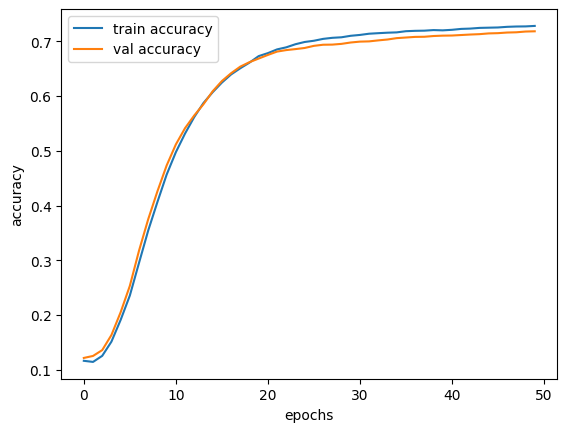

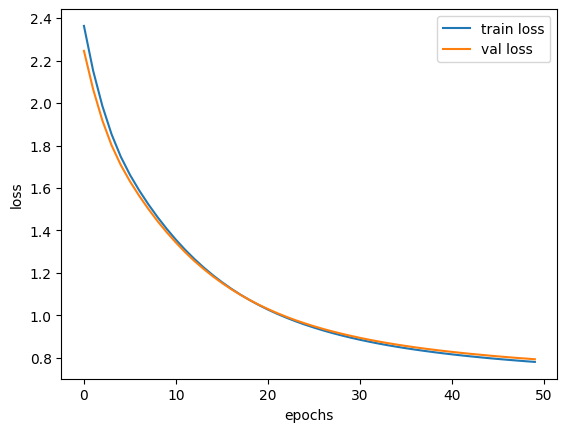

In [5]:
from CNNBiLSTM_LoadData import draw_history
draw_history(history,50)

In [5]:
import tensorflow as tf
import numpy as np
model=tf.keras.models.load_model("temp/CNNBiLSTM_image_resnet182d_46.h5")
x_test = np.load('VideoFramePickle/x_test.npy')
y_test = np.load('VideoFramePickle/y_test.npy')
x_test = x_test.reshape(-1,50,50,3)
y_test = np.repeat(y_test, repeats=10, axis=0)
loss,acc = model.evaluate(x_test,y_test)
print(f"loss {loss},acc {acc}")

1780/1780 [==============================] - 15s 8ms/step - loss: 1.7793 - accuracy: 0.7347
loss 1.7793134450912476,acc 0.7347092628479004
